In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from PIL import Image
import numpy as np
from src.gan import getGanModel

import cv2
import pandas as pd
import os
from tqdm import tqdm

In [19]:
def plotSaveImage(image, savePath = ''):
    data = (image.numpy() * 255)[0]
    plt.imshow(data)
    plt.show()
    if len(savePath):
        rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save(savePath)

In [20]:
def getImages(rootPath, imageList):
    images = []
    for i in imageList:
        temp = cv2.imread(rootPath + i)
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        temp = temp / 255
        images.append(temp)
    return np.array(images)

In [21]:
def getMetaData(rawData, start, batchSize, rootPath = ''):
    picNames = rawData[start:start+batchSize, 0]
    attributes = rawData[start:start+batchSize, 1:]
    attributes = np.asarray(attributes).astype('float32')
    attributes += 0.05 * np.random.random(attributes.shape)
    
    if len(rootPath):
        images = getImages(rootPath, picNames)
        return (images, attributes)
    return (picNames, attributes)

In [22]:
gan, generator, discriminator = getGanModel()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 128, 128, 3)


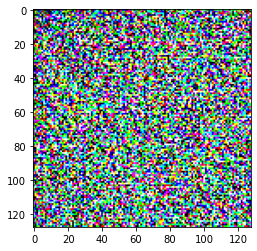

In [23]:
# Test Generator image
features = tf.random.normal(shape=[1, 40])
randomNoise = tf.random.normal(shape=[1, 100])
# gImage = generator([np.array([features,features,features]), np.array([randomNoise,randomNoise,randomNoise])], training=False)
gImage = generator([features, randomNoise], training=False)
print(gImage.shape)
plotSaveImage(gImage)


In [24]:
decision = discriminator([features, gImage])
print(decision)


tf.Tensor([[0.5003005]], shape=(1, 1), dtype=float32)


In [14]:
picsPath = 'P:/GAN Learning/Face_Generation/datasets/29561_37705_bundle_archive/img_align_celeba/processed/'
csvPath = 'P:/GAN Learning/Face_Generation/datasets/29561_37705_bundle_archive/list_attr_celeba.csv'
data = pd.read_csv(csvPath)
numpyData = data.values

In [24]:
batchSize = 25
start = 0
iterations = 50
randomNoiseLength = 100

discriminatorLosses = []
adversaryLosses = []

for step in tqdm(range(iterations)):    
    # Fetching the images and their attributes from Hard drive
    realImages, attributes = getMetaData(numpyData, start, batchSize, picsPath)
    
    # Random vector (2nd Generator Input)
    randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
    
    # Generating fake images
    generatedImages = generator.predict([attributes, randomVector])
    
    # Combining 50% fake and 50% real images as well as attributes for discriminator
    combinedImages = np.concatenate([generatedImages, realImages])
    combinedAttributes = np.concatenate([attributes, attributes])
    # 0 => Label for fake images, 1 => Label for real images >>> Used to train Discriminator
    labels = np.concatenate([np.zeros((batchSize, 1)), np.ones((batchSize, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    # Training Discriminator
    discriminatorLoss = discriminator.train_on_batch([combinedAttributes, combinedImages], labels)
    discriminatorLosses.append(discriminatorLoss)
    
    # Preparing to train Generator
    misleadingTargets = np.ones((batchSize, 1))
    misleadingTargets += .05 * np.random.random(misleadingTargets.shape)
    
#     # Random vector (2nd Generator Input)
#     randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
    
    # Training Generator
    adversaryLoss = gan.train_on_batch([randomVector, attributes], misleadingTargets)
    adversaryLosses.append(adversaryLoss)
    
    start += batchSize
    if start > len(numpyData) - batchSize:
        start = 0
    
    if step % 50 == 49:
        print('Iterations: %d/%d, d_loss: %.4f,  a_loss: %.4f. ' % (step + 1, iterations, discriminatorLoss, adversaryLoss))
        control_image = np.ones((128 * 5, 128 * 5, 3))
        for i in range(25):
            x_off = i % 5
            y_off = i // 5
            control_image[x_off * 128:(x_off + 1) * 128, y_off * 128:(y_off + 1) * 128, :] = generatedImages[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save("myop/%d.png" % (step))

        

  0%|▎                                                                               | 10/2500 [00:05<24:20,  1.70it/s]

Iterations: 10/2500, d_loss: 0.0066,  a_loss: 4.0081. 


  2%|█▊                                                                              | 55/2500 [00:31<23:41,  1.72it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

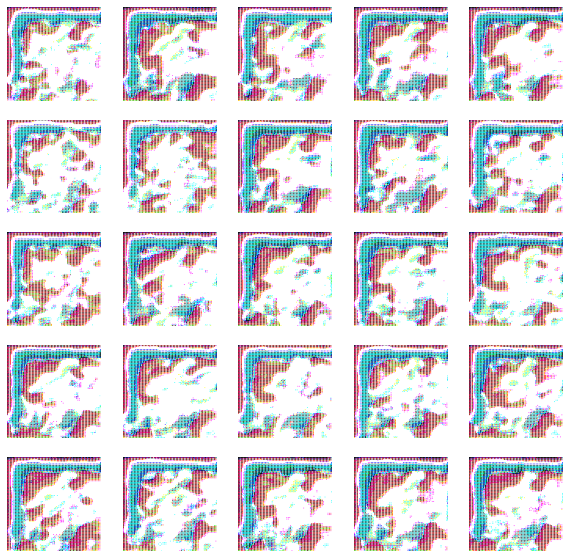

In [16]:
tempGeneratedImages = generatedImages * 255

plt.figure(1, figsize=(10, 10))
for i in range(batchSize):
    plt.subplot(5, 5, i+1)
    plt.imshow(tempGeneratedImages[i])
    plt.axis('off')
plt.show()